# Azure-ML experiment on salary dataset
Special thanks to Janakiram MSV youtube channel for relevant tutorial.

# 1) Import standard Python modules

In [1]:
import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import Azure ML SDK modules
import azureml.core
from azureml.core import Workspace
from azureml.core.model import Model
from azureml.core import Experiment
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage
from azureml.core.webservice import AciWebservice
from azureml.core.conda_dependencies import CondaDependencies

In [3]:
#Check Azure ML SDK version
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.21


# 2)Create Azure ML Workspace

In [ ]:
AZ_SUBSCRIPTION_ID='Your_Azure_Subscription_ID'
ws = Workspace.create(name='Text_analysis_review',
                      subscription_id=AZ_SUBSCRIPTION_ID, 
                      resource_group='Machine_Learn',
                      create_resource_group=True,
                      location='West Europe'
                     )

### 2.1) Write configuration to local file

In [6]:
ws.write_config()

Wrote the config file config.json to: C:\Users\69785hsh\Downloads\Data Science\Learning Projects\Azure_ML\aml_config\config.json


### 2.2) Create Azure ML Experiment

In [7]:
exp = Experiment(workspace=ws, name='textexp')

### 2.3) Start logging metrics

In [8]:
run = exp.start_logging()                   
run.log("Experiment start time", str(datetime.datetime.now()))

# 3) Load dataset

In [10]:
dataset = pd.read_csv('Restaurant_Reviews.tsv.txt', delimiter='\t', quoting=3)
dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [11]:
dataset.shape

(1000, 2)

### 3.1) Cleaning

In [13]:
corpus = [] # defining corpus
for i in range(0, len(dataset['Review'])): # giving range of values from 0 to 1000
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i]) # using i for all values instead of 1 column
    #review = re.sub('[%s]' % re.escape(string.punctuation), '', dataset['Review'][i])
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    stopword_set = set(stopwords.words('english'))
    review = [ps.stem(word) for word in review if not word in stopword_set]
    review = ' '.join(review)
    corpus.append(review) # finally attach all these cleaned values to corpus directory

### 3.2) Count Vector

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=1500) # Remove irrelavant words like nouns "ricksteve" in dataset
# 1500 comes from amount of words our sparse matrix has converted to. We had 1565 columns.
#So we took 1500 for safe assumption that we get rid of useless words.
X = cv.fit_transform(corpus).toarray() # X is used as matrix of feature to be coverted as spare matrix
# .array is used to created corpus i.e list into matrix. Each word is in its own columnn

In [15]:
y = dataset.Liked # y is series now
y=dataset.Liked.values # y is integer now

### 3.3)Split the train and test data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

### 3.4)Train the model

In [17]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [18]:
y_pred = classifier.predict(X_test)
y_pred

array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0], dtype=int64)

### 3.5)Checking Predict value

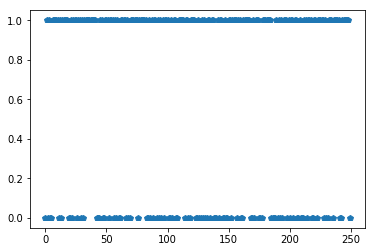

In [19]:
import matplotlib.pyplot as plt
plt.plot(y_pred, "p")

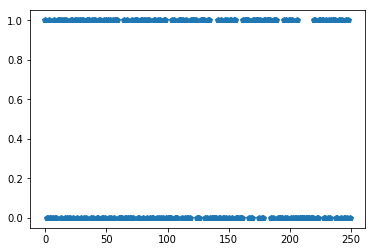

In [20]:
# checking y-test and see difference
plt.plot(y_test, "p")

### 3.6) confusion Matrix

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[70, 60],
       [24, 96]], dtype=int64)

### 3.7) Checking accuracy score

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.664

In [23]:
from sklearn.metrics import classification_report
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.54      0.62       130
           1       0.62      0.80      0.70       120

   micro avg       0.66      0.66      0.66       250
   macro avg       0.68      0.67      0.66       250
weighted avg       0.68      0.66      0.66       250



### 3.8)Freeze the model (Pickle)

In [24]:
filename = 'text_model.pkl'
joblib.dump(classifier, filename)

['text_model.pkl']

### 3.9)End Azure ML Experiment

In [25]:
run.log("Experiment end time", str(datetime.datetime.now()))
run.complete()

### 3.10)Get Portal URL

In [26]:
print(run.get_portal_url())

https://mlworkspace.azure.ai/portal/subscriptions/167db103-850f-40a6-9a18-6e2b38edc465/resourceGroups/Machine_Learn/providers/Microsoft.MachineLearningServices/workspaces/Text_analysis_review/experiments/textexp/runs/e86b308f-6ece-4c3a-81f0-005d6f051542


# 4) Deploying the model

### 4.1) Register the model

In [27]:
model = Model.register(model_path = "text_model.pkl",
                       model_name = "text_model",
                       tags = {"key": "1"},
                       description = "Text Classifier",
                       workspace = ws)

Registering model text_model


### 4.2) Define Azure ML Deploymemt configuration

In [28]:
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "text",  "method" : "sklearn"}, 
                                               description='Finding +ve/-ve reviews using text classifier')

### 4.3)Create enviroment configuration file

In [29]:
textenv = CondaDependencies()
textenv.add_conda_package("scikit-learn")

with open("textenv.yml","w") as f:
    f.write(textenv.serialize_to_string())
with open("textenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will

# be automatically provisioned for runs with userManagedDependencies=False.


# Details about the Conda environment file format:

# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually


name: project_environment
dependencies:
  # The python interpreter version.

  # Currently Azure ML only supports 3.5.2 and later.

- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.

  - azureml-defaults
- scikit-learn



## 4.4)Create Azure ML Scoring file

In [30]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB

from azureml.core.model import Model

def init():
    global model
    # retrieve the path to the model file using the model name
    model_path = Model.get_model_path('text_model')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    return json.dumps(y_hat.tolist())

Overwriting score.py


### 4.5)Deploy the model to Azure Container Instance

In [31]:
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="textenv.yml")

### 4.6) Expose web service

In [32]:
service = Webservice.deploy_from_model(workspace=ws,
                                       name='text-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config)

service.wait_for_deployment(show_output=True)

Creating image
Image creation operation finished for image text-svc:1, operation "Succeeded"
Creating service
Running........................
SucceededACI service creation operation finished, operation "Succeeded"


### 4.7) Get the Web Service URL

In [33]:
print(service.scoring_uri)

http://13.93.35.48:80/score


### 4.8) Delete Workspace and clean up resources

In [35]:
ws.delete()